In [3]:
!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [6]:
df=pd.read_csv('/content/imdb-dataset-of-50k-movie-reviews.zip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.shape

(50000, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
df.describe().T

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,positive,25000


In [10]:
df.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


In [49]:
# Function to clear the texts
def clean_text_basic(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stopwords = set(["i", "me", "my", "you", "your", "he", "she", "it", "they", "them", "and", "the", "a", "of", "to", "in", "on", "for", "with", "as", "at", "by", "is", "was", "are", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "but", "if", "or", "because", "while", "how", "all", "any", "some", "one", "two", "three", "that", "which", "who", "whom", "this", "these", "those"])
    text = " ".join([word for word in text.split() if word not in stopwords])
    return text

# Function for TF-IDF Feature Extraction
def extract_features(X_train, X_test):
    tfidf = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    return X_train_tfidf, X_test_tfidf, tfidf

# Function to Label Encode
def label_encode(y_train, y_test):
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    return y_train_encoded, y_test_encoded, le

In [50]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred, model_name):
    auc = roc_auc_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [53]:
# Function to train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    X_train, X_test = X_train.apply(clean_text_basic), X_test.apply(clean_text_basic)
    print("Step 1: cleaning done")

    X_train_tfidf, X_test_tfidf, tfidf = extract_features(X_train, X_test)
    print("Step 2: TF-IDF done")

    y_train_encoded, y_test_encoded, le = label_encode(y_train, y_test)
    print("Step 3: Label Encoding done")

    classifiers = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'DecisionTree': DecisionTreeClassifier()
    }

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model_scores = {}

    for name, model in classifiers.items():
        cv_scores = cross_val_score(model, X_train_tfidf, y_train_encoded, cv=kfold, scoring='f1_weighted')
        print(f"{name} F1 Score: {np.mean(cv_scores):.4f}")
        model_scores[name] = np.mean(cv_scores)

    best_model_name = max(model_scores, key=model_scores.get)
    best_model = classifiers[best_model_name]

    best_model.fit(X_train_tfidf, y_train_encoded)
    y_pred = best_model.predict(X_test_tfidf)
    results = {
        'F1 Score': f1_score(y_test_encoded, y_pred, average='weighted'),
        'Precision': precision_score(y_test_encoded, y_pred, average='weighted'),
        'Recall': recall_score(y_test_encoded, y_pred, average='weighted'),
        'Accuracy': accuracy_score(y_test_encoded, y_pred)
    }

    print(f"Best Model: {best_model_name}")
    print("Evaluation Metrics:\n", results)
    print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred))

    plot_confusion_matrix(y_test_encoded, y_pred, best_model_name)
    plot_roc_curve(y_test_encoded, y_pred, best_model_name)

    return best_model, results, tfidf, le


In [52]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=40)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40000,)
Shape of X_test: (10000,)
Shape of y_train: (40000,)
Shape of y_test: (10000,)


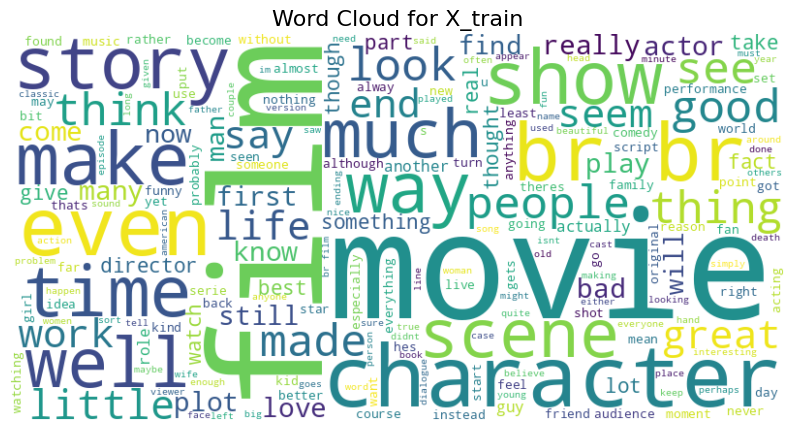

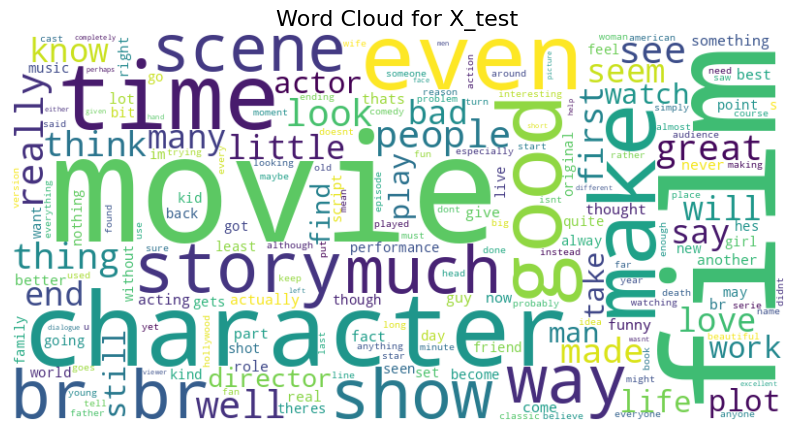

In [29]:
from wordcloud import WordCloud

def plot_wordcloud(data, title):
    text = " ".join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

plot_wordcloud(X_train.apply(clean_text_basic), title="Word Cloud for X_train")
plot_wordcloud(X_test.apply(clean_text_basic), title="Word Cloud for X_test")

Step 1: cleaning done
Step 2: TF-IDF done
Step 3: Label Encoding done
LogisticRegression F1 Score: 0.8875
DecisionTree F1 Score: 0.7101
Best Model: LogisticRegression
Evaluation Metrics:
 {'F1 Score': 0.8886109230755628, 'Precision': 0.888753286225764, 'Recall': 0.8886, 'Accuracy': 0.8886}

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      5100
           1       0.88      0.90      0.89      4900

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



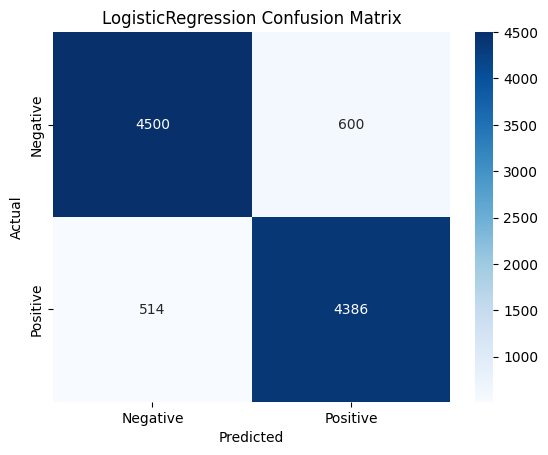

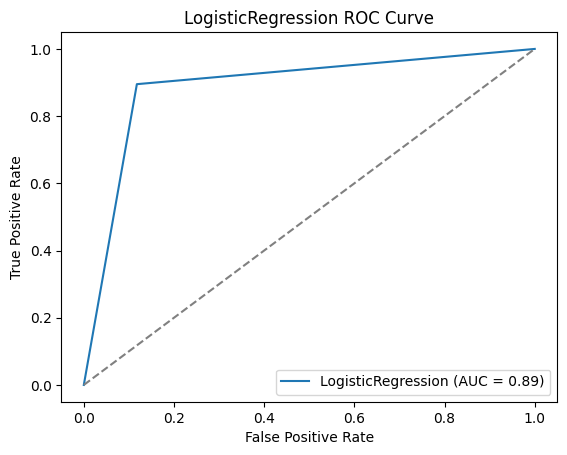

In [54]:
# Train and evaluate models
best_model, results, tfidf, le = train_and_evaluate_models(X_train, X_test, y_train, y_test)

In [55]:
import pickle

# Saving
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [56]:
def predict(model, text, tfidf, le):
    text = clean_text_basic(text)
    text_tfidf = tfidf.transform([text])
    prediction = model.predict(text_tfidf)
    return le.inverse_transform(prediction)[0]

In [58]:
print(predict(best_model, "The movie was sucks!", tfidf, le))

negative


In [59]:
print(predict(best_model, "The movie was superb!", tfidf, le))

positive
